1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



32.97989844019469


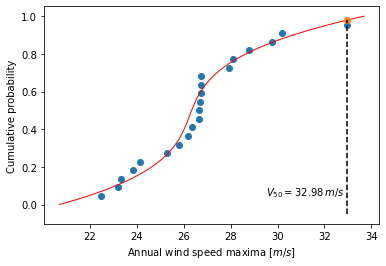

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import UnivariateSpline
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

cprob = [i/(years_nb + 1) for i in range(1, years_nb+1)]
max_speeds = np.sort(max_speeds)
spl = UnivariateSpline(cprob, max_speeds)
xs = np.linspace(0, 1, 100)

plt.plot(max_speeds,cprob,'o', markersize=6)
plt.plot(spl(xs),xs,'-', color='red', lw=1)
fifty_prob = 1. - 0.02
fifty_wind = spl(fifty_prob)
plt.plot(fifty_wind, fifty_prob, 'o')
plt.text(29.5, 0.05, '$V_{50} = %.2f \, m/s$' % fifty_wind)
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'k--')
plt.xlabel('Annual wind speed maxima [$m/s$]')
plt.ylabel('Cumulative probability')
print(fifty_wind)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

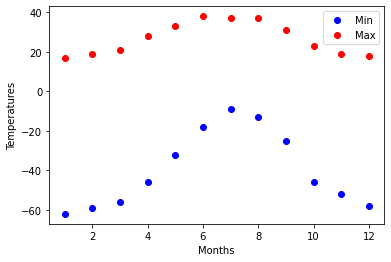

In [2]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_data = np.arange(1,13)
min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
max = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
plt.plot(x_data, min, 'o', color = 'blue', label = 'Min')
plt.plot(x_data, max, 'o', color = 'red', label = 'Max')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.legend()

[23.0920866   6.73581633  2.29443578 15.77931936]
[ 52.64929254   7.16452592   1.97590026 -61.32093787]


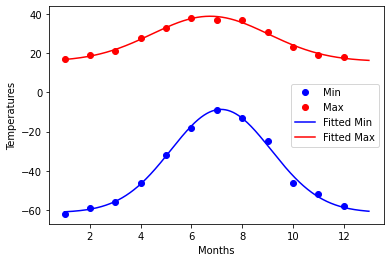

In [3]:
#the points seem to be distributed as a gaussian, so let's try with a gaussian function
from scipy import optimize
def gaussian(x, a, µ, sigma, b):
    return a*np.exp(-(x - µ)**2/(2*(sigma**2))) + b
x = np.arange(1,13,0.01)
params_min, params_covar_min = optimize.curve_fit(gaussian, x_data, min, p0 = [60, 6, 1, -61])
params_max, params_covar_max = optimize.curve_fit(gaussian, x_data, max, p0 = [30, 6, 3, 20])
print(params_max)
print(params_min)
plt.plot(x_data, min, 'o', color = 'blue', label = 'Min')
plt.plot(x_data, max, 'o', color = 'red', label = 'Max')
plt.plot(x, gaussian(x, params_min[0], params_min[1], params_min[2], params_min[3]), label='Fitted Min', color = 'blue')
plt.plot(x, gaussian(x, params_max[0], params_max[1], params_max[2], params_max[3]), label='Fitted Max', color = 'red')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.show()

***The fit is reasonable***

In [4]:
#time offset
params_min[1]-params_max[1]

0.4287095885722998

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


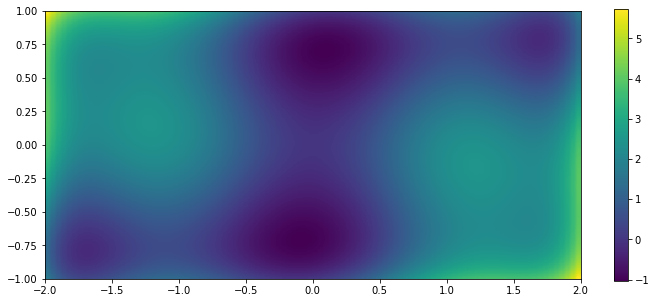

In [5]:
from matplotlib import pylab
def f(var):
    x = var[0]
    y = var[1]
    return (4-2.1*np.power(x,2)+np.power(x,4)/3)*np.power(x,2)+x*y+(4*np.power(y,2)-4)*np.power(y,2)
x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)
x, y = np.meshgrid(x,y)
plt.figure(figsize = (12, 5))
fig = pylab.imshow(f([x,y]), extent= [-2,2,-1,1])
plt.colorbar(fig)
plt.show()

In [6]:
guess = [0,0.76]
optmin = optimize.minimize(f, guess)
print(optmin.x, optmin.fun)
guess = [0,-0.75]
optmin = optimize.minimize(f, guess)
print(optmin.x, optmin.fun)
guess = [-1.75,-0.74]
optmin = optimize.minimize(f, guess)
print(optmin.x, optmin.fun)
guess = [1.75,0.74]
optmin = optimize.minimize(f, guess)
print(optmin.x, optmin.fun)
guess = [0,0]
optmin = optimize.minimize(f, guess)
print(optmin.x, optmin.fun)

[-0.08984201  0.7126564 ] -1.0316284534898772
[ 0.08984201 -0.71265641] -1.0316284534898772
[ 0.08984202 -0.71265639] -1.0316284534898759
[-0.08984202  0.71265639] -1.0316284534898759
[0. 0.] 0.0


### The initial guess of [0, 0] leads to an evident error: the minimum is found in [0, 0], where the function value is equal to 0.

In [7]:
from scipy.optimize import basinhopping

x0 = [-2,-1]
solution = basinhopping(f, x0, stepsize=1)
solution

                        fun: -1.0316284534898774
 lowest_optimization_result:       fun: -1.0316284534898774
 hess_inv: array([[ 0.12949138, -0.00796165],
       [-0.00796165,  0.06160121]])
      jac: array([ 4.47034836e-08, -1.34110451e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([ 0.08984201, -0.7126564 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 3660
                        nit: 100
                       njev: 1220
                          x: array([ 0.08984201, -0.7126564 ])

### **There seems to be 2 global minima, with the function value at those points almost equal to -1.0316284534898772**.

### Called several times, the basinhopping method returns both the global minimun in [-0.08984201  0.7126564 ] and in [ 0.08984201 -0.71265641], with the function minimum value equal to -1.0316284534898772 or -1.0316284534898774, confirming that there are 2 global minima.

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

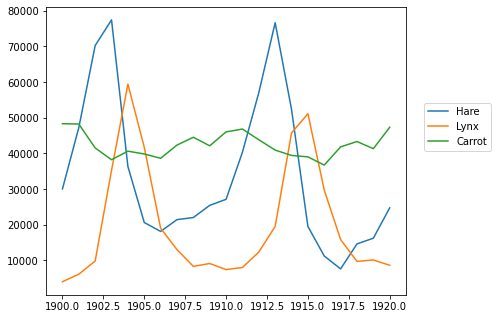

In [8]:
import numpy as np
data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T


from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,5))
plt.axes([0.2, 0.1, 0.5, 0.8]) 
plt.plot(year, hares, year, lynxes, year, carrots) 
plt.legend(('Hare', 'Lynx', 'Carrot'), loc=(1.05, 0.5)) 
plt.show()

<ipython-input-25-c73dd5bea3ea>:13: RuntimeWarning: divide by zero encountered in true_divide
  hares_per = 1 / hares_freq


The peak perdiod of hares is = 10.5 seconds


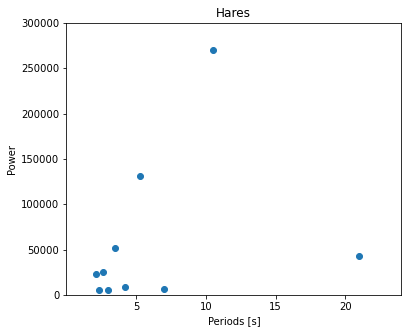

In [25]:
from scipy import fftpack

# The FFT of the signals
hares_fft = fftpack.fft(hares)

# And the power
power = np.abs(hares_fft)

# The corresponding frequencies
hares_freq = fftpack.fftfreq(hares.size)

#The corresponding perdiods
hares_per = 1 / hares_freq

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.scatter(hares_per, power)
plt.xlabel('Periods [s]')
plt.ylabel('Power')
plt.xlim(0.00001, 24)
plt.ylim(0,300000)
plt.title('Hares')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(hares_freq > 0)
freqs = hares_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
print('The peak perdiod of hares is = {} seconds'.format(1/peak_freq))

<ipython-input-26-3608158a154f>:11: RuntimeWarning: divide by zero encountered in true_divide
  sig_per = 1 / sig_freq


The peak perdiod of lynxes is = 10.5 seconds


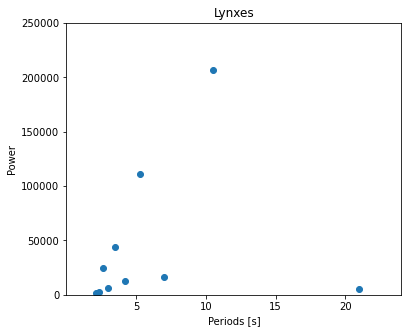

In [26]:
# The FFT of the signals
sig_fft = fftpack.fft(lynxes)

# And the power
power = np.abs(sig_fft)

# The corresponding frequencies
sig_freq = fftpack.fftfreq(lynxes.size)

#The corresponding perdiods
sig_per = 1 / sig_freq

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.scatter(sig_per, power)
plt.xlabel('Periods [s]')
plt.ylabel('Power')
plt.xlim(0.00001, 24)
plt.ylim(0,250000)
plt.title('Lynxes')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sig_freq > 0)
freqs = sig_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
print('The peak perdiod of lynxes is = {} seconds'.format(1/peak_freq))

The peak perdiod of carrots is = 10.5 seconds


<ipython-input-156-990878195c62>:10: RuntimeWarning: divide by zero encountered in true_divide
  sig_per = 1 / sig_freq


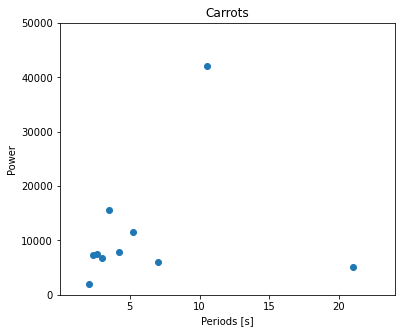

In [156]:
# The FFT of the signals
sig_fft = fftpack.fft(carrots)

# And the power
power = np.abs(sig_fft)

# The corresponding frequencies
sig_freq = fftpack.fftfreq(carrots.size)

#The corresponding perdiods
sig_per = 1 / sig_freq

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.scatter(sig_per, power)
plt.xlabel('Periods [s]')
plt.ylabel('Power')
plt.xlim(0.00001, 24)
plt.ylim(0,50000)
plt.title('Carrots')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sig_freq > 0)
freqs = sig_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
print('The peak perdiod of carrots is = {} seconds'.format(1/peak_freq))

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

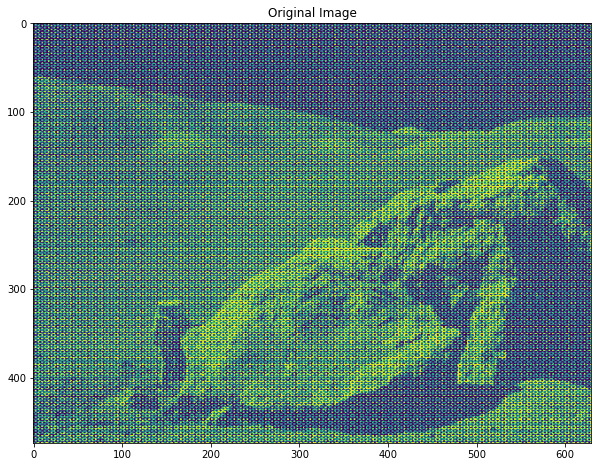

In [157]:
pic = plt.imread('/Users/michelecrudele/LaboratoryOfComputationalPhysics_Y3/moonlanding.png')
plt.figure(figsize=(10,8))
plt.imshow(pic)
plt.title('Original Image')
plt.show()

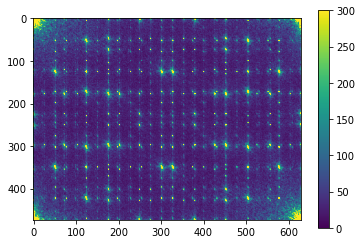

Text(0, 0.5, 'plower')

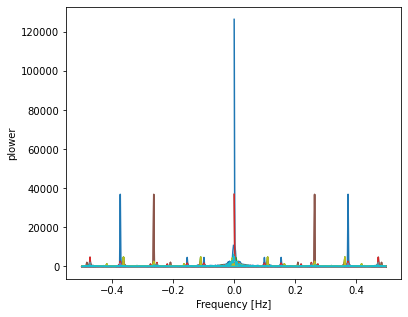

In [158]:
#it is necessary to normalize data, otherwise the range of the interval is so large that the color of the image results uniform

from matplotlib.colors import Normalize
F = fftpack.fft2(pic)
power = np.abs(F)    
sample_freq = fftpack.fftfreq(pic.shape[0])
plt.imshow(power, norm=Normalize(0, 300));
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

In [159]:
print(F)

[[126598.46      -0.j        -4608.579  -1892.4691j
    -322.0927   -20.277735j ...   -906.1584 +1539.3083j
    -322.0927   +20.277735j  -4608.579  +1892.4691j  ]
 [ -9421.1    +5242.114j      5224.017  -3171.743j
    1607.9927 +1269.4243j   ...   -677.345   -936.16174j
     354.62457-1003.8347j     1965.366  -2188.0593j  ]
 [ -2928.3508 +7280.916j     -1116.4069 +1338.3181j
    -474.20056 +385.40207j  ...    239.77225 -977.2128j
    1582.9283  -261.9535j     2641.927   -292.0936j  ]
 ...
 [  1850.5717 -2451.1785j     -781.0807   +13.744507j
     377.90704  +12.66983j  ...  -1526.7867 +1271.2621j
   -2705.5718 -3488.5286j     1897.4039 -2281.9092j  ]
 [ -2928.3508 -7280.916j      2641.927   +292.0936j
    1582.9283  +261.9535j   ...  -2208.43     +81.80743j
    -474.20056 -385.40207j   -1116.4069 -1338.3181j  ]
 [ -9421.1    -5242.114j      1965.366  +2188.0593j
     354.62457+1003.8347j   ...   1190.5853 -1431.9934j
    1607.9927 -1269.4243j     5224.017  +3171.743j   ]]


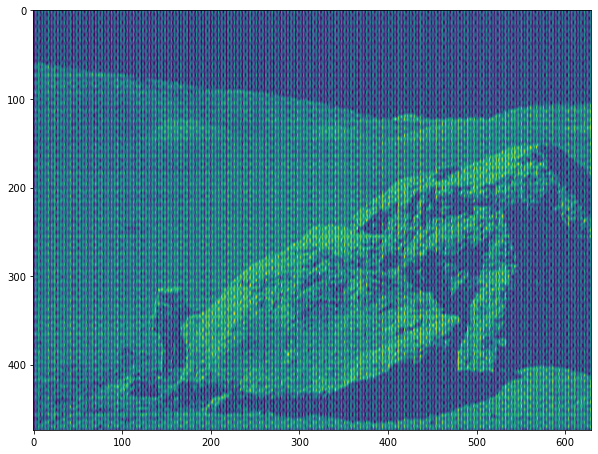

In [170]:
high_freq_fft = F.copy()
high_freq_fft[np.abs(sample_freq) > 0.2] = 0
filtered_sig = fftpack.ifft2(high_freq_fft)
plt.figure(figsize=(10,8))
plt.imshow(abs(filtered_sig))